<a href="https://colab.research.google.com/github/aligtr/ml/blob/master/Pr22_MulticlassClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

# Мультиноминальная классификация

# Классификация классификаций

В задаче классификации выделяют несколько типов:

- Бинарная - классификация по принципу один из двух возможных: да/нет, правда/ложь, пойдет дождь/будет солнечно и т.д.;
- Мультиименная (**One vs Rest**) - навешиваем ярлыки (лэйблы, тэги), предсказание может содержать высокую уверенность в нескольких классах сразу;
- Многоклассовая (Мультиноминальная / **Multinominal**) - присваивается один (единственный) из доступных классов;

Случаи бинарной и мультиименной классификаций мы уже рассматривали. Мультиклассовая классификация отличается от ранее расмотренных, так как ранее при наличии множества классов мы могли поработать с каждым классом практически по-отдельности, то здесь накладывается ограничение: результатом может быть единственный класс из доступных.

Для примера, на вход модели подается рукописная цифра от нуля до девяти, задача модели - классифицировать, какая из цифр нарисована на рисунке.


Теперь создадим набор данных для работы с ними:

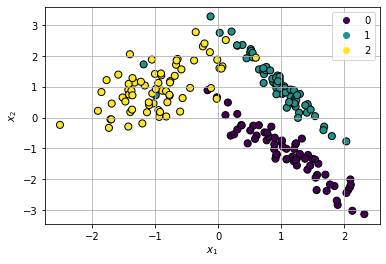

In [2]:
from sklearn.datasets import make_classification

X_data, y_data = make_classification(
    n_samples=210,
    n_features=2, 
    n_redundant=0,
    n_informative=2, 
    n_clusters_per_class=1,
    n_classes=3,
    random_state=RANDOM_STATE
)

pnts_scatter = plt.scatter(X_data[:, 0], X_data[:, 1], marker='o', c=y_data, s=50, edgecolor='k', )
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1', '2'])

# Функция предказания

## Формирование предсказания в виде вектора

В бинарной классификации мы предсказывали скаляры, либо значение уверенности присвоения положительному классу для конкретной записи в данных, либо значение индекса класса (0 или 1 ~ отрицательный или положительный случай).

В случае, например, трех классов, задача усложняется, так как предсказанием модели для одной записи должен быть вектор, состоящий из трех элементов, каждый из которых отражает уверенность присвоения данному классу:
$$
h_W(x^{(i)}) = [0.15, 0.8, 0.05]
$$

Мы помним, что $X$ - матрица данных (меняться она никак не должна), а вот веса ранее являлись вектором. Так как веса относятся к модели, которую мы применяем, то они могут поменяться и теперь они представляют собой не вектор, а матрицу:
$$
W = 
\begin{bmatrix}
w^{[1]}_0 & w^{[2]}_0 & \dots & w^{[c]}_0 \\
w^{[1]}_1 & w^{[2]}_1 & \dots & w^{[c]}_1 \\
\vdots & \vdots & \ddots & \vdots & \\
w^{[1]}_m & w^{[2]}_m & \dots & w^{[c]}_m \\
\end{bmatrix}
$$

Матрица имеет размерность $[m, c]$, где $m$ - количество признаков (+1 для логистической регресси), $c$ - количество предсказываемых классов. 

> Можно рассматривать такое представление как $c$ линейных моделей.

Таким образом, результат линейного умножения в матричном виде должен быть представлен как:
$$
z(X) = XW =
\begin{bmatrix}
z^{(1)[1]} & z^{(1)[2]} & \dots & z^{(1)[c]} \\
z^{(2)[1]} & z^{(2)[2]} & \dots & z^{(2)[c]} \\
\vdots & \vdots & \ddots & \vdots & \\
z^{(n)[1]} & z^{(n)[2]} & \dots & z^{(n)[c]} \\
\end{bmatrix}
$$

> Линейная часть регрессии так и остается в виде $z(X) = XW$.

Размерность $[n, c]$, $n$ - количество записей в данных.

При этом истинные значения все также располагаются в векторе размером $[n, 1]$, и каждый элемент может иметь значения в диапазоне $[0; c)$ (индекс класса).

Как же тогда соединить показатели уверенности, которые располагаются в матрице $[n, c]$, и вектор истинных значений для сравнения $[n, 1]$?


Для выполнения ограничения задачи вводится дополнительная функция **Softmax** вместо функции сигмоиды:
$$
\sigma^{[k]}(z)=\frac{e^{z^{[k]}}}{\sum_{c}e^{z^{[c]}}}
$$ 

где $c$ - количество предсказываемых классов, $k$ - индекс обрабатываемого элемента в векторе линейного предсказания.

Эту функцию мы применяем к каждой строке матрицы $z(X)$ и на выходе получаем матрицу такого же размера, но уже **сумма элементов в кажной строке равна единице**.

> Допустим, результатом функции $z(x^{(i)})$ (это строка в матрице $z(X)$) для $i$-й записи данных является вектор $[4.5, 0.8, 6.4]$, тогда выходом функции Softmax является вектор $[0.13, 0.003, 0.867]$. Такое представление говорит о том, что модель на 13% уверена, что запись принадлежит классу 0, на 0.3% - классу 1 и на 86.7% - классу 2.

После обработки вектора с помощью функции Softmax выполняется **получение индекса элемента вектора с наибольшим значением**, что и является результатом предсказания функции: $[0.13, 0.003, 0.867] \rightarrow 2$.

Таким образом, после применения функции Softmax и определения индекса максимального значения в векторе для каждой записи мы получаем вектор предсказаний, соответствующий по формату вектору истинных значений.

Для примера:
```python
y_true = [0, 2, 1, 2, 2, 1]
y_pred = [1, 2, 2, 1, 0, 1]
```

Визуально реализацию задачи в общем виде классификации можно представить следующим образом:

![Схема](https://docs.google.com/uc?export=download&id=1MTBiwNND0Pnw9a-wtlfSTf2Fw1djJUW5)

На рисунке видно, что модель создает Logits - это сырые степени уверенности. Для случая бинарной классификации по каждой записи предсказывается скалярная степень уверенности. Для мультиименной и мультиноминальной - вектор степеней уверенностей (каждый элемент вектора - уверенность в присвоении класса по индексу).

После получения сырых степеней уверенности они нормируются:
- Бинарная и мультиименная - каждый элемент результата проходит черех сигмоиду;
- Мультиноминальная - каждый вектор уверенностей проходит через Softmax.

Этап предсказания заключается в очень простых операциях:
- Бинарная и мультиименная - каждый элемент сравниваем с порогом и присваиваем бинарное состояние;
- Мультиноминальная - находим индекс максимального элемента -> это и будет индексом класса в качестве предсказания.

Настало время реализации данного функционала. Напишем необходимые функции для выполнения предсказания:

In [164]:
# TODO - напишите функции вычисления softmax и предсказания
def softmax(z):
    e_z=np.exp(z)
    z_norm=e_z/np.sum(e_z)
    return z_norm


def predict_proba(X, W):
    '''
    Предсказание нормированных степеней уверенности
    '''
    X=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    z=np.dot(X,W)
    y_proba=np.ndarray((z.shape))
    for iter in range(X.shape[0]):
      y_proba[iter,:]=softmax(z[iter,:])
    return y_proba


def predict(X, W):
    '''
    Предсказание индексов классов
    '''
    z=predict_proba(X,W)
    y_pred=np.argmax(z,axis=1)
    return y_pred

In [165]:
# Проверка
X = np.array([
    [1, 2],
    [-3, 4],
    [1, 2],
    [-1, 1],
    [0, 5],
    [0, -2],
])

W = np.array([
    [1, 2, 0],
    [0, 2, 1],
    [2, 2, 0]
])

y_prob = predict_proba(X, W)
y_pred = predict(X, W)

y_pred_true = np.array([1, 0, 1, 0, 1, 2])

assert np.all(y_pred == y_pred_true)
assert np.all(np.abs(np.sum(y_prob, axis=1)-np.ones(X.shape[0])) < 1e-8)

# Метрики

## Матрица ошибок для многих классов

Раньше мы рассмотрели представление матрицы ошибок: 
<table>
    <thead>
        <tr>
            <th></th>
            <th colspan=2>Предсказание</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=3>Истинное</td>
            <td></td>
            <td>0</td>
            <td>1</td>
        </tr>
        <tr>
            <td>0</td>
            <td>TN</td>
            <td>FP</td>
        </tr>
        <tr>
            <td>1</td>
            <td>FN</td>
            <td>TP</td>
        </tr>
    </tbody>
</table>


Такое представление матрицы удобно для задач бинарной классификации, так как у нас всего два класса. Но лучше запомнить правило распределения для многих классов, чтобы потом было проще воспринимать. $TP$ для класса $k$ - это элемент в матрице по индексам $[k, k]$ (то есть на диагонали в ряду и колонке $k$). Все остальные элементы на диагонали - это $TN$ для этого класса $k$. Аналогично для класса $k$ все элементы в ряду ($[k, :]$) кроме диагонального элемента являются $FN$, а все элементы в колонке ($[:, k]$) кроме диагонального элемента являются $FP$. Вот так постараемся описать общий вид:

<table>
    <thead>
        <tr>
            <th></th>
            <th colspan=2>Предсказание</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=4>Истинное</td>
            <td></td>
            <td>0</td>
            <td>1</td>
            <td>k</td>
        </tr>
        <tr>
            <td>0</td>
            <td>$TP_0$</td>
            <td>$FP_1$ / $FN_0$</td>
            <td>$FP_k$ / $FN_0$</td>
        </tr>
        <tr>
            <td>1</td>
            <td>$FP_0$ / $FN_1$</td>
            <td>$TP_1$</td>
            <td>$FP_k$ / $FN_1$</td>
        </tr>
        <tr>
            <td>k</td>
            <td>$FP_0$ / $FN_k$</td>
            <td>$FP_1$ / $FN_k$</td>
            <td>$TP_k$</td>
        </tr>
    </tbody>
</table>

Расшифровывается это следующим образом:
- Для класса 0, по индексу $[0, 0]$ это $TP$, все остальные элементы на диагонали - $TN$, все остальные элементы в ряду - $FN$ (видите индекс снизу), все остальные элементы в колонке - $FP$ (тоже индекс 0).
- Для класса $k$, по индексу $[k, k]$ это $TP$, все остальные элементы на диагонали - $TN$, все остальные элементы в ряду - $FN$, все остальные элементы в колонке - $FP$.

Такое представление немного сложнее четырех элементов, но оно универсальнее и проще в реализации в коде!

## Задание

С учетом ранее изученных методов визуальной и численной оценки классификатора произведите разделение данных на выборку обучения/тестирования и проведите оценку работы классификатора на данных со случайно заданными весами:

> Для разделения воспользуйте функцией `sklearn.model_selection.train_test_split` из пакета `sklearn` и обратите внимание на аргумент `stratify`

In [166]:
rand_W = np.array([
    [-1, -2, -2],
    [-7, 2, -3],
    [-1, 1, 4],
])

In [167]:
# TODO - произведите разделение данных
# NOTE - не забудьте зафиксировать RANDOM_STATE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_data,y_data,train_size=0.7, random_state=RANDOM_STATE,stratify=y_data)

In [168]:
# Проверка
assert np.all([
    X_train.shape[0] == 147, 
    X_test.shape[1] == X_data.shape[1], 
    y_test.shape[0] == 63,
    y_test[y_test == 2].shape[0] == 20
])

In [169]:
def plot_2d_decision_boundary(X, W, y_true):
    x1_vals = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 100)
    x2_vals = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 100)
    xx, yy = np.meshgrid(x1_vals, x2_vals)

    y_pred = predict(np.c_[xx.ravel(), yy.ravel()], W)
    y_pred = y_pred.reshape(xx.shape)

    plt.contourf(xx, yy, y_pred)
    pnts_scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, s=30, edgecolor='k')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(True)
    plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1','2'])
    plt.show()

def get_confusion_matrix(y_true, y_pred):
    class_count = np.max(y_true)+1;
    conf_matrix=np.ndarray((class_count,class_count))
    for i in range(class_count):
      for j in range(class_count):
        conf_matrix[i,j]=np.sum((y_true==i)&(y_pred==j))
      conf_matrix[i,i]=np.sum((y_true==i)&(y_pred==i))
    return conf_matrix


def draw_confusion_matrix(conf_matrix):
    ax = sns.heatmap(conf_matrix, annot=True)
    plt.xlabel('Предсказанное')
    plt.ylabel('Истинное')
    plt.show()


# TODO - функции вычисления метрик 
def calculate_accuracy(y_true, y_pred):
    # TODO - функция вычисления точности
    conf_matrix = get_confusion_matrix(y_true, y_pred)
    acc=(conf_matrix[0,0]+conf_matrix[1,1])/np.sum(conf_matrix)
    return acc

def calculate_recall_precision_f1(y_true, y_pred, class_index):
    '''
    class_index - Индекс класса для которого делается оценка показателей
    '''
    # TODO - функция вычисления показателей recall, precision
    conf_matrix = get_confusion_matrix(y_true, y_pred)
    recall=conf_matrix[class_index,class_index]/(conf_matrix[class_index,class_index]+conf_matrix[class_index,class_index-1])
    precision=conf_matrix[class_index,class_index]/(conf_matrix[class_index,class_index]+conf_matrix[class_index-1,class_index])
    f1=2*recall*precision/(recall+precision)
    return recall, precision, f1

In [170]:
X = X_test
y_true = y_test
y_pred = predict(X, rand_W)
print(f'Accuracy: {calculate_accuracy(y_true, y_pred)}')
print(f'Class 0 metrics: {calculate_recall_precision_f1(y_true, y_pred, 0)}')
print(f'Class 1 metrics: {calculate_recall_precision_f1(y_true, y_pred, 1)}')
print(f'Class 2 metrics: {calculate_recall_precision_f1(y_true, y_pred, 2)}')

Accuracy: 0.25396825396825395
Class 0 metrics: (0.5, 0.09090909090909091, 0.15384615384615385)
Class 1 metrics: (0.9375, 0.4411764705882353, 0.6)
Class 2 metrics: (1.0, 0.625, 0.7692307692307693)


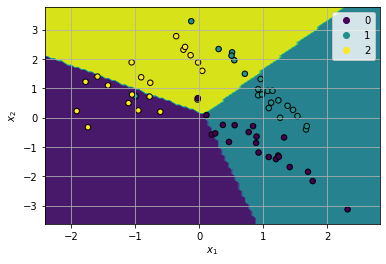

In [171]:
plot_2d_decision_boundary(X, rand_W, y_true)

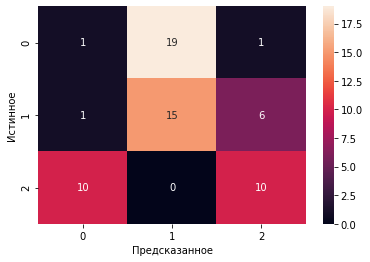

In [172]:
conf_mtrx = get_confusion_matrix(y_true, y_pred)
draw_confusion_matrix(conf_mtrx)

Еще раз взглянем на матрицу ошибок. Таким образом удобно представлять работу классификатора даже для случая многих классов, так как такое представление позволяет увидеть, как модель ведет себя.

> Одной особенностью матрицы ошибок является то, что сумма каждой строки по стобцам должна давать точно такое количество значений класса, сколько есть в векторе истинных значений. Проверьте, для класса 2 (желтые кружки) мы получаем $10+10=20$ записей, можно подсчитать в векторе `y_true`, что количество действительно равно 20. *Эта особенность является хорошей проверкой на корректность работы кода и формирования результатов.*

# Функция потерь

## One-Hot кодирование (One-Hot Encoding ~ OHE)

Разработанные функции позволяют получить вектор предсказаний и он соотносится с вектором истинных значений. Как пример:
```python
y_true = [0, 2, 1, 2, 2, 1]
y_pred = [1, 2, 2, 1, 0, 1]
```

С помощью функции потерь мы можем оценить как далеко от истинны находится вектор предсказания. Одним из вариантов является использование $MSE$ для данного случая, но практика показывает, что для мультиноминальной классификации подходит другой вариант функции потерь, так как у $MSE$ расстояние между индексами 0 и 2 будут больше, чем расстояние между 0 и 1, что вносит искажение в смысл, так как классы по факту должны быть равнозначны.

Как и ранее производилось сравнение значений в диапазоне $[0; 1]$ с помощью функции $BCE$, можно также произвести преобразование данных для аналогичного сравнения в диапазоне $[0; 1]$. Для этого применяется подход One-Hot Encoding.

Суть OHE метода заключается в том, что каждый индекс класс в векторе мы заменяем на вектор, состоящий из нулей и единиц. Делается это путем размещения единицы в векторе на место по индексу номера класса. Количество возможных значений (а в нашем случае - это количество предсказываемых классов) определяет длину вектора:
- Класс $0 \rightarrow [1, 0, 0, 0, 0]$
- Класс $3 \rightarrow [0, 0, 0, 1, 0]$

> Такой способ кодирования не привязан в функции потерь и используется во многих других методах.

In [173]:
# TODO - функция кодирования вектора индексов классов в представление OHE
def onehot_encode(y):
    # NOTE - для получения размера вектора воспользуйтесь максимальным значением
    #   из вектора y
    class_count=np.max(y)+1
    y_ohe=np.zeros((len(y),class_count))
    for i in range(len(y)):
      y_ohe[i,y[i]]=1;
    return y_ohe

In [174]:
# Проверка
y_ohe = onehot_encode([1, 2, 1, 2, 1, 0])

y_ohe_true = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [0, 1, 0],
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0]
])
assert np.all(y_ohe == y_ohe_true)

## Категориальная кросс-энтропия

В случае мультиноминальной классификации результатом может быть лишь один из предсказываемых классов в векторе. Достигается это за счет использования функции Softmax. При этом вектор истинных значений должен содержать лишь одну единицу.

В случае с мультиименной классификацией мы просто сравниваем каждый элемент вектора истины с каждым элементом предсказания и получаем суммарное отклонение (по аналогии с бинарной классификацией), так как значения внутри вектора между собой не связаны. В данном случае функция Softmax выделит одно из значений так, что один элемент вектора будет иметь значение больше других - этим и воспользуемся при разработке функции потерь: 
$$
J=-{\sum_{k=1}^{K}y^{[k]}*log(\hat{y}^{[k]})}
$$ 
где $K$ - количество предсказываемых классов, $\hat{y}$ - нормированный (Softmax) вектор степеней уверенности, $y$ - вектор истинных значений в формате OHE.

> Такое представление вычисляет $J$ для одной записи в данных, для полного объема данных требуется найти среднее всех полученных значений $J$.

В чем логика? Почему всего одна часть из BCE? Все очень просто - мы проходим по каждому элементу вектора предсказания и, если это целевой класс, то пытаемся максимизировать его значение к единице. А теперь вспомните, какая зависимость в результате Softmax? Правильно, сумма элементов равна единице, так что при максимизации целевого класса к единице мы автоматически сводим остальные элементы вектора предсказания к нулю, как и записано в векторе истины. PROFIT!

> Название ей - категориальная кросс-энтропия (Categorical cross-entropy)

Для примера, если мы имеет три класса, и конкретная 10я запись в данных классифицирована как класс 1 (закодированный истинный вектор $[0, 1, 0]$), а предсказанные нормированные вероятности (после Softmax) $[0.1, 0.6, 0.3]$, то функция потерь будет выглядеть
$$
J = -(0*log(0.1) + 1*log(0.6) + 0*log(0.3))
$$

Как видите, закодированное истинное значение работает как простая маска.

# Производная функции потерь

В данной практике мы пропустим вывод производной функции потерь и введем сразу представление:

$$
\frac{\partial J}{\partial w^{[k]}_{j}} = X^T(\hat{y}-y)
$$

где $k$ - индекс класса $[0; K]$, $j$ - индекс признака $[0; M]$. Размерность матрицы градиента $[M, K]$.

Хороший пример того, как выводится на примере двух классов представлен здесь: https://stats.stackexchange.com/questions/235528/backpropagation-with-softmax-cross-entropy

In [175]:
# TODO - функция потерь и функция получения матрицы производных
def cce_loss(y_true, y_pred_proba):
    y_ohe=onehot_encode(y_true)
    J=-np.sum(y_ohe*np.log(y_pred_proba),axis=1)
    loss=np.mean(J)
    return loss

def cce_loss_deriv(X, y_true, y_pred_proba):
    y_ohe=onehot_encode(y_true)
    dJ=np.dot(X.T,(y_pred_proba-y_ohe))
    return dJ

In [176]:
# Проверка
y_true = np.array([0, 1, 2, 3])
y_pred_proba = np.array([
  [0.98, 0.01, 0.01, 1e-8],
  [0.6, 0.1, 1e-8, 0.3],
  [0.1, 0.2, 0.4, 0.3],
  [0.2, 0.1, 0.1, 0.6],
])

X = np.array([
    [1, 2, 3],
    [2, 3, 4],
    [8, 9, 0],
    [7, 6, 5],
])

loss = cce_loss(y_true, y_pred_proba)
dJ = cce_loss_deriv(X, y_true, y_pred_proba)

dJ_true = np.array([
    [ 3.38      ,  0.51      , -4.08999998,  0.20000001],
    [ 3.86      , -0.28      , -4.77999997,  1.20000002],
    [ 3.34      , -3.07      ,  0.53000004, -0.79999997]
])

assert loss == 0.9374760389879278
assert np.all(np.abs(dJ-dJ_true) < 1e-8)

In [134]:
loss

0.9374760389879278

# Обучение

## Задание

Настало время обучить нашу модель и эта задача переходит вам! Давайте напишем функцию обучения модели. Учтите следующие особенности:
- в ходе обучения применяется степень уверенности, а не конечный предсказанный класс;
- функция `predict_proba()` принимает на вход исходные данные и сама добавляет колонку, функция `сce_loss_deriv()` более общая и не добавляет колонку единиц.

In [177]:
# TODO - функция обучения и функция отображения истории обучения
def fit_model(X, y, lr, n_iter):
    # Создаем 
    y_ohe = onehot_encode(y)
    K = y_ohe.shape[1]
    M = X.shape[1]+1
    new_W = np.zeros((M, K))
    loss_history = []
    x_lin=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    print(f'Data shape: {X.shape}')
    print(f'Start weights: {new_W}')
    
    for i_iter in range(n_iter):
        y_pred = predict_proba(X,new_W)
        loss = cce_loss(y, y_pred)
        dJ = cce_loss_deriv(x_lin,y,y_pred)
        new_W = new_W - lr*dJ        
        loss_history.append(loss)

    print(f'Result weights: {new_W}')
    return new_W, loss_history


def show_loss(loss_history):
    plt.plot(loss_history)
    plt.grid()
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('$J(X)$')
    plt.show()

In [147]:
def fit_model(X, y, lr, n_iter):
    y_ohe = onehot_encode(y)
    K = y_ohe.shape[1]
    M = X.shape[1]+1
    W = np.zeros((M, K))
    X_linreg = np.c_[np.ones(X.shape[0]), X]
    loss_history = []
    for i_iter in range(n_iter):
        y_pred = predict_proba(X, W)
        loss = cce_loss(y, y_pred)
        dJ = cce_loss_deriv(X_linreg, y, y_pred)
        W -= lr*dJ
        loss_history.append(loss)
    print(f'Result weights: {W}')
    return W, loss_history


def show_loss(loss_history):
    plt.plot(loss_history)
    plt.grid()
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('$J(X)$')
    plt.show()

Data shape: (147, 2)
Start weights: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Result weights: [[ 1.04832897 -1.22392346  0.17559449]
 [ 0.02893671  2.62942935 -2.65836606]
 [-2.38206462  1.49561089  0.88645373]]


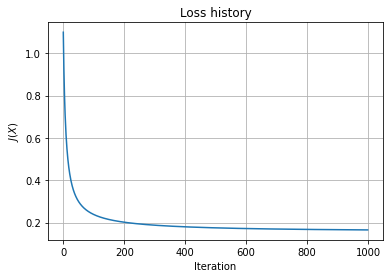

In [178]:
trained_W, loss_history = fit_model(
    lr=0.001,
    n_iter=1000,
    X=X_train,
    y=y_train
)

show_loss(loss_history)

Отлично, если значение функции потерь постепенно снижается в истории, значит все сделано верно, давайте теперь посмотрим, как работает обученная модель.

Отобразите метрики, матрицу ошибок и визуализируйте пространство принятия решений:

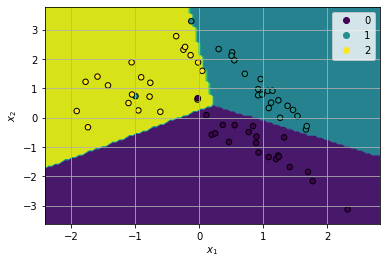

In [179]:
plot_2d_decision_boundary(X_test, trained_W, y_test)

Accuracy: 0.6349206349206349
Class 0 metrics: (0.9523809523809523, 1.0, 0.975609756097561)
Class 1 metrics: (1.0, 1.0, 1.0)
Class 2 metrics: (1.0, 0.9090909090909091, 0.9523809523809523)


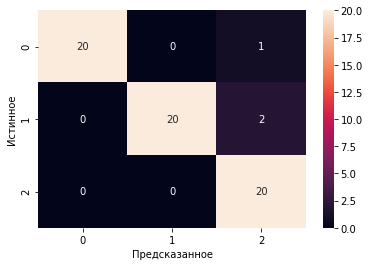

In [180]:
X = X_test
y_true = y_test
y_pred = predict(X, trained_W)

print(f'Accuracy: {calculate_accuracy(y_true, y_pred)}')
print(f'Class 0 metrics: {calculate_recall_precision_f1(y_true, y_pred, 0)}')
print(f'Class 1 metrics: {calculate_recall_precision_f1(y_true, y_pred, 1)}')
print(f'Class 2 metrics: {calculate_recall_precision_f1(y_true, y_pred, 2)}')

conf_mtrx = get_confusion_matrix(y_true, y_pred)
draw_confusion_matrix(conf_mtrx)

Замечательно! Модель обучена и работает лучше, чем со случайными весами.

# Разработка модели с помощью класса

Чтож, вот мы и познакомились с базовыми задачами в обучении с учителем и основными моделями для их решения. Но на этом наша практика не заканчивается! Впереди нас ждут больше моделей и подходов, а сейчас мы познакомимся с одним из подходов, которому обязательно нужно научиться, чтобы улучшить читаемость кода и упростить его. Сейчас мы напишем нашу модель логической регрессии в виде класса!

> Воу!

Суть такого подхода в том, что модель логистической регрессии представляет собой просто веса. Также, модель “может” обучаться и делать предсказания. До этого мы во все функции передавали веса и пользовались отдельными функциями, но по факту все это относится к модели, поэтому мы воспользуемся объектно-ориентированным подходом и реализуем класс логистической регрессии, а потом создадим объект этого класса и воспользуемся его методами. В качестве атрибута класс будет содержать веса, а его методами будут методы предсказания и обучения.


In [206]:
# TODO - реализуйте класс логистической регрессии
class LogisticRegression:
    def __init__(self):
        # В начале инициализируем веса как None, что означает "модель не обучена"
        self.W = None

    def onehot_encode(self,y):
        # NOTE - для получения размера вектора воспользуйтесь максимальным значением
        #   из вектора y
        class_count=np.max(y)+1
        y_ohe=np.zeros((len(y),class_count))
        for i in range(len(y)):
          y_ohe[i,y[i]]=1;
        return y_ohe

    def cce_loss(self,y_true, y_pred_proba):
        y_ohe=self.onehot_encode(y_true)
        J=-np.sum(y_ohe*np.log(y_pred_proba),axis=1)
        loss=np.mean(J)
        return loss

    def cce_loss_deriv(self,X, y_true, y_pred_proba):
        y_ohe=self.onehot_encode(y_true)
        dJ=np.dot(X.T,(y_pred_proba-y_ohe))
        return dJ

    def predict_proba(self, X):
        # Проверяем веса, если они None (через is - так проверяется тип),
        #   тогда сообщаем об ошибке, так как надо сначала обучить модель!
        if self.W is None:
            print('Model is not trained!')
            return None
        X=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
        z=np.dot(X,self.W)
        y_proba=np.ndarray((z.shape))
        for iter in range(X.shape[0]):
          y_proba[iter,:]=self.softmax(z[iter,:])
        # TODO - напишите продолжение предсказания
        return y_proba
    
    def softmax(self,z):
        e_z=np.exp(z)
        z_norm=e_z/np.sum(e_z)
        return z_norm

    def predict(self, X):
        # Проверяем веса, если они None (через is - так проверяется тип),
        #   тогда сообщаем об ошибке, так как надо сначала обучить модель!
        if self.W is None:
            print('Model is not trained!')
            return None
        z=self.predict_proba(X)
        y_pred=np.argmax(z,axis=1)
        # TODO - напишите продолжение предсказания
        return y_pred

    def fit(self, X, y, n_iter, lr):
        # Для начала нужно инициализировать массив весов с размером (M, K)
        y_ohe = self.onehot_encode(y)
        K = y_ohe.shape[1]
        M = X.shape[1]+1
        self.W = np.zeros((M, K))
        loss_history = []
        x_lin=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
        #print(f'Data shape: {X.shape}')
        #print(f'Start weights: {self.W}')
        
        for i_iter in range(n_iter):
            y_pred = self.predict_proba(X)
            loss = self.cce_loss(y, y_pred)
            dJ = self.cce_loss_deriv(x_lin,y,y_pred)
            self.W = self.W - lr*dJ        
            loss_history.append(loss)

        #print(f'Result weights: {self.W}')
        # TODO - затем произвести обучения
        # NOTE - возвращать веса не нужно, они являются атрибутом класса 
        #   и должны храниться внутри модели

Accuracy: 0.6349206349206349
Class 0 metrics: (0.9523809523809523, 1.0, 0.975609756097561)
Class 1 metrics: (1.0, 1.0, 1.0)
Class 2 metrics: (1.0, 0.9090909090909091, 0.9523809523809523)


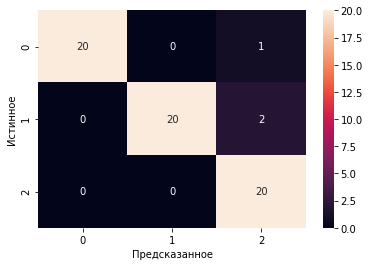

In [207]:
# Проверим
logreg_model = LogisticRegression()
logreg_model.fit(
    X_train, y_train,
    lr=0.01,
    n_iter=100
)

y_pred = logreg_model.predict(X_test)

print(f'Accuracy: {calculate_accuracy(y_test, y_pred)}')
print(f'Class 0 metrics: {calculate_recall_precision_f1(y_test, y_pred, 0)}')
print(f'Class 1 metrics: {calculate_recall_precision_f1(y_test, y_pred, 1)}')
print(f'Class 2 metrics: {calculate_recall_precision_f1(y_test, y_pred, 2)}')

conf_mtrx = get_confusion_matrix(y_test, y_pred)
draw_confusion_matrix(conf_mtrx)

Проверьте себя, метрики и матрица ошибок должны получиться такими же, как и при обучении ранее.

> Может вам и не кажется на данный момент код более удобным или читаемым, но представьте, если модель будет содержать не только веса, а еще ворох параметров - передавать их каждый раз в функции!? Практика разработки с использование объектной модели - это очень хорошая практика, так что вы можете в будущем попробовать писать без нее, но если язык позволяет (а Python поддерживает ООП), то это может сильно упростить разработку!

## Задание

Произведите оценку работы модели с использованием кросс-валидации и класса `LogisticRegression`. В качестве метрики для оценки используйте среднюю F1 по всем классам.

> Для получения фолдов со стратификацией воспользуйтесь функцией из модуля `sklearn.model_selection.StratifiedKFold`

In [208]:
# TODO - функция оценки работы модели кросс-валидацией с пятью фолдами 
# NOTE - не забудьте зафиксировать RANDOM_STATE
from sklearn.model_selection import StratifiedKFold 

# NOTE - обратите внимание, в качестве агрумента передаем модель, 
#   которую будем проверять
def cross_val_score_f1(X, y, k_folds, model):
    f1_values = []
    skf = StratifiedKFold(n_splits=k_folds, random_state=RANDOM_STATE)
    for train_index, test_index in skf.split(X, y):
        loss_history = model.fit(
        lr=0.01,
        n_iter=100,
        X=X_data[train_index],
        y=y_data[train_index]
        )
        y_pred = model.predict(X_data[test_index])
        for i in range(3):
          _,_, f1 = calculate_recall_precision_f1(y_data[test_index], y_pred, 0)
          f1_values.append(f1)
    #print(np.mean(f1_values))
    return np.mean(f1_values)

In [209]:
# Используем!
logreg_model = LogisticRegression()

f1_result = cross_val_score_f1(X_data, y_data, k_folds=5, model=logreg_model)
print(f1_result)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9772079772079771


# Выводы - Задание

Классическая рубрика - "Напиши вывод сам". Не стесняйтесь шевелить извилинами и искать причинно-следственные связи. И как обычно несколько вспомогательных вопросов, чтобы было проще начать. 

1. В каких случаях необходимо использовать мультиноминальную классификацию? 
2. Что позволяет оценить функция потерь? И зачем нужна эта оценка? 
3. Как это "обучение с учителем"?

Мультиноминальная классификация используется, объекты оценки можно разделить более чем на 2 класса. При этом фугкция потерь как и веса становятся матрицами, так как мы оцениваем степень принадлежности к каждому классу. Для того чтобы получить конкретное предсказание функция мотерь нормализуется функцией Softmax и берется в качестве ответа класс с набольшей степенью принадлежности.
Обучение с учителем - это способ машинного обучения, при котором веса целевой функции меняются в соответствии со степеью близости ответа модели и реальных значений.
 

# Вопросики! 

1. Что используется в мультиноминальной классификации вместо сигмоиды? 
2. Почему MSE для случае мультиноминальной классификации - не лучший выбор? 
3. Что такое ОНЕ и где это использовать? 
4. В чём категориальность категориальной кросс-энтропии? 
5. Зачем оборачивать модель логистической регрессии в класс? Какие преимущества это даёт? 


1. Вместо сигмоиды используется функция Sotfmax.
2. MSE показывает просто отклонение. у бедет разное между классами с разными индексами (то есть, например, отклонение от класса 0 к классу 1 и 2 могут быть одинаковыми, но при этомотличаться на единицу, что довольно не равнозначно).
3. OHE = one-hor encoding - метод при котором номер класса заменяется на строку из нулей с единицей по  индексу номера класса. позмоляет реализовать ВСЕ для мультиноминальной классификации.
4. В категориальной кросс-энтропии мы в функция Sotfmax с помощью ОНЕ выделяем только нужный нам класс для каждого набора данных и его оптимизируем.
5. Модель оборачивается в класс, чтобы не писать постоянно хвост из множества переменных. Они превращаются в параметры класса. Это может улучшить читаемость кода.



# Доклады

- Модель K-NearestNeighbours (KNN)